In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print("adding following folder to path: ",module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

adding following folder to path:  /home/enis/projects/nna/src


In [2]:
import numpy as np 
from numpy import linspace
import pandas as pd


import datetime
from scipy import stats
import time
import copy
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_fscore_support


import csv 
from pathlib import Path
from os import listdir
import pickle

from tabulate import tabulate


from datetime import datetime,timedelta

import itertools


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import ListedColormap
from matplotlib import cm

from pytz import timezone




In [3]:
from pre_process_func import read_queue
from fileUtils import read_file_properties
from labeling_utils import load_labels
from visUtils import get_cycle,createTimeIndex,file2TableDict,reverseTableDict

In [4]:
dataFlder="/home/enis/projects/nna/data/"
resultsFlder="/home/enis/projects/nna/results/"


In [5]:
file_properties_df=pd.read_pickle("../../data/realdata_v2No_stinchcomb.pkl")

#important to keep them in order
file_properties_df.sort_values(by=['timestamp'],inplace=True)

# delete older than 2016
fromtime=datetime(2016, 1, 1, 0)
file_properties_df=file_properties_df[file_properties_df.timestamp>=fromtime]


In [6]:
# example of data

file_properties_df.loc[Path('/tank/data/nna/real/ivvavik/AR03/2018/INP-AR-03_20180513_060000.flac')]

site_id                        AR03
locationId                     AR03
site_name                          
recorderId                INP-AR-03
hour_min_sec                 060000
year                           2018
month                            05
day                              13
region                      ivvavik
timestamp       2018-05-13 06:00:00
durationSec                     600
timestampEnd    2018-05-13 06:10:00
Name: /tank/data/nna/real/ivvavik/AR03/2018/INP-AR-03_20180513_060000.flac, dtype: object

In [47]:
# PARAMS
# FREQS to reduce results 
freq="2H"


# possible places to pick
# sorted(pd.unique(file_properties_df.site_id.values))
# areas to be visualized


selected_areas=["15","21","22","27","31","35","37","48",]

id2name={}
id2name['09-USGS']="USGS"
id2name['19-Itkillik2']="Itkilik 2"
id2name['01-Itkillik']="Itkilik 1"
id2name['02-Colville2']="Colville 2"
id2name['03-OceanPt']="Ocean Pt"
id2name['04-Colville4']="Colville 4"
id2name['05-Colville5']="Colville 5"

In [44]:

globalindex,all_start,all_end=createTimeIndex(selected_areas,file_properties_df,freq)

selected_tag_name="Clipping"
model_tag_names=[selected_tag_name]
weather_cols=[]

globalcolumns=model_tag_names#selected_areas+weather_cols


In [9]:
print(" Duration of selected data period:",(all_end-all_start).days,"days")
print(" Starts: {} \n Ends:   {}".format(all_end,all_start))

 Duration of selected data period: 64 days
 Starts: 2019-07-07 23:59:59 
 Ends:   2019-05-04 00:00:00


In [11]:
# gathered_results_perTag

In [29]:
# result_path="/scratch/enis/data/nna/real/"
def loadResults(filename,threshold=0.5,channel=1):
    # try:
    if not filename.exists():
        return []
    result=np.load(filename)
    prob2binary(result,threshold=0.5,channel=channel)

    return result

def prob2binary(result,threshold=0.5,channel=1):
    if channel==2:
        result=np.min(result,axis=1)
    result[result>threshold]=1
    result[result<=threshold]=0
    result=result[:(result.size//10)*10]

    result=result.reshape(10,-1).max(axis=0)
    return result

# with open("/home/enis/projects/nna/data/8tags_on_8sites_DF.pkl", 'ab') as  dffile:
#             # source, destination
#     pickle.dump(df_dict, dffile)
def file2TableDict(selected_areas,model_tag_names,globalindex,globalcolumns,
                    file_properties_df,freq,dataFreq="10S",dataThreshold=0.5,channel=1,gathered_results_perTag=None,result_path=None):



    df_dict={key: None for (key) in selected_areas}
    no_result_paths=[]

    #we need to load it from files
    if gathered_results_perTag==None and result_path==None:
        print("ERROR: gathered_results_perTag or result_path should be defined")
        return None

    for i,area in enumerate(selected_areas):
        df_sums = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)
        df_count = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)

        for tag_name in model_tag_names:
    #         for afile in selected_areas_dict[area]:
            area_filtered=file_properties_df[file_properties_df.site_id==area]
            for afile,row in area_filtered.iterrows():
        #         data=gathered_results[afile][0]
                afile=Path(afile)
                # we either load data from multiple files or from single one
                if gathered_results_perTag==None:
                    # TODO, make _FCmodel variable
                    filename=standardPathStyle(result_path,row,subDirectoryAddon="_FCmodel"
                                        ,fileNameAddon="_FCmodel000.npy")
                    data=loadResults(filename,threshold=dataThreshold,channel=channel)
                        # gathered_results[file]=result[:]
                else:
                    data=gathered_results_perTag[tag_name].get(afile,[])[:]
                    data=prob2binary(data,threshold=0.5,channel=channel)

                if type(data)==list:
                    no_result_paths.append(afile)
                    pass

                start=file_properties_df.loc[afile]["timestamp"]
                index = pd.date_range(start,start+timedelta(seconds=(10*(len(data)-1))), freq=dataFreq)

                df_afile=pd.DataFrame(data,index=index,columns=[tag_name])

                df_afile_grouped = df_afile.groupby([pd.Grouper(freq=freq)])
                counts=df_afile_grouped.count()
                sums=df_afile_grouped.sum()
                df_count.update(counts)
                df_sums.update(sums)

        df_dict[area]=(df_count.copy(),df_sums.copy())

    return df_dict,no_result_paths

In [12]:
# result_path="/scratch/enis/data/nna/real/"
# input_fpath="/tank/data/nna/real/"
tag_name="clipping"
dataFolderPath="/home/enis/projects/nna/data/"
clippingResultsPath=dataFolderPath+"clipping_results/"
threshold=0.01  # if x <= then 0

# data=gathered_results_perTag[tag_name].get(afile,[])[:]

gathered_results_perTag={"Clipping":{}}

gathered_results={}
selected_areas_files={}
for i,area in enumerate(selected_areas):
    to_be_deleted=[]
    fileName=(clippingResultsPath+area+"_1.pkl")
    resultsDict=np.load(fileName,allow_pickle=True)
    resultsDict=resultsDict[()]
    gathered_results_perTag["Clipping"].update(resultsDict)



In [30]:
# result_path="/scratch/enis/data/nna/real/"

result_path="/home/enis/projects/nna/data/clipping_results/"

df_dict,no_result_paths = file2TableDict(selected_areas,model_tag_names,globalindex,globalcolumns,
                    file_properties_df,freq,dataFreq="10S",dataThreshold=0.01,channel=2,gathered_results_perTag=gathered_results_perTag,result_path=None)
print("{} number of files do not have results".format(len(no_result_paths)))

df_dict_reverse=reverseTableDict(selected_areas,df_dict,model_tag_names)


0 number of files do not have results


In [191]:
# gathered_results[Path('/tank/data/nna/real/prudhoe/15/2019/S4A10283_20190531_164602.flac')]

In [33]:
df_count,df_sums=df_dict_reverse[selected_tag_name]

In [34]:
df_sums.sum() # NEW

15    5414.0
21    7356.0
22    6999.0
27    5942.0
31    4454.0
35    2158.0
37    3013.0
48    7624.0
dtype: float64

In [178]:
df_sums.sum() # OLD
# 15    117614
# 21    136276
# 22    130189
# 27    102127
# 31    102120
# 35     74482
# 37     73438
# 48    142705
# dtype: int64

15    117614
21    136276
22    130189
27    102127
31    102120
35     74482
37     73438
48    142705
dtype: int64

In [35]:
df_freq=df_sums/df_count
# del df_freq['UMIAT']

df_freq=df_freq*100
df_freq=df_freq.dropna(how='all')
# df_freq=pd.concat([df_freq, normal_weather], axis=1, join='inner')

In [36]:
# df_freq=df_sums[:]
# df_freq=pd.concat([df_freq, sums], axis=1, join='outer')

In [37]:
# df_freq=(df_freq-df_freq.min())/(df_freq.max()-df_freq.min())


In [38]:
df_freq.sum() # New

15    12211.060606
21    16594.898990
22    15784.393939
27    13397.929293
31    10043.080808
35     4862.676768
37     6795.757576
48    17199.898990
dtype: float64

In [182]:
df_freq.sum() #Old

15    26448.512480
21    30238.896940
22    28974.836745
27    22774.074074
31    22543.657407
35    16666.250000
37    16336.851852
48    31741.185588
dtype: float64

In [39]:

# cord_list=sorted(list(cord.items()),key=lambda x: x[1][0],reverse=True)

# cord_list=list(filter(lambda x: x[0] in df_freq.columns ,cord_list))

cord_list=[(i,(0,0)) for i in df_freq.columns]

In [143]:
# (datetime.datetime(2019, 5, 4, 0, 0),
#  datetime.datetime(2019, 6, 24, 23, 59, 59))

In [144]:
# df_freq.loc['2019-05':'2019-05']

In [40]:
months=[df_freq.loc['2019-05':'2019-05'],df_freq.loc['2019-06':'2019-06']]
# months2=[df_freq.loc['2016-06-01':'2016-06-30'],df_freq.loc['2016-07-01':'2016-07-31'],df_freq.loc['2016-08-01':'2016-08-31']]

# make them all same month for aligning 
for i,month in enumerate(months):
    months[i]=month.rename(index=lambda x: x.replace(month=7))
    


In [41]:
# for i,month in enumerate(months):
#     print(month)

In [42]:
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),
    ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


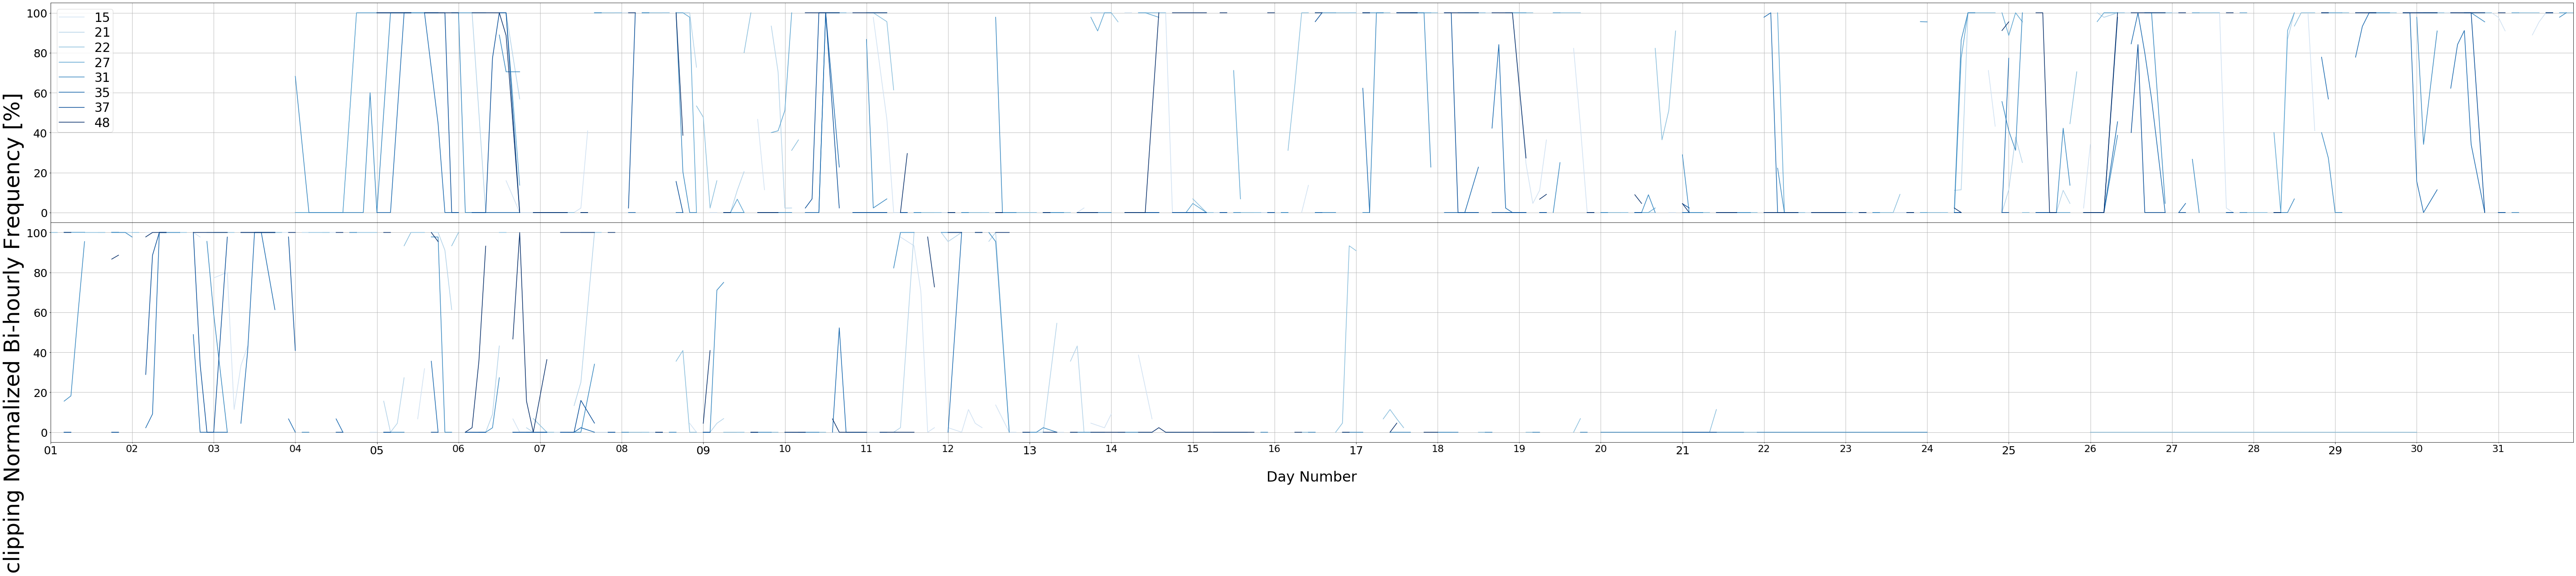

In [49]:

plt.rcParams["axes.prop_cycle"] = get_cycle("Blues",N=8)


fig, ax = plt.subplots(figsize=(80,18),nrows=len(months),sharex=True, sharey=True,gridspec_kw={'hspace': 0})

markers = itertools.cycle((',', '+', '.', 'o', '*')) 

weather_colors=["firebrick","darkorange","green","seagreen","lightpink"]

for monthi,month in enumerate(months):
    # for col in df_freq.columns:
    for i,(col,(lat,long)) in enumerate(cord_list):
        if col in weather_cols:
            index=weather_cols.index(col)
            ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ",color=weather_colors[index])
        else:
            ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ")
        

ax[0].legend( labels=[id2name.get(x[0],x[0]) for x in cord_list],loc='upper left', 
            borderpad=0.2, labelspacing=0.2, fontsize=28, 
            frameon=True) # frameon=False to remove frame.


ax[1].set_ylabel('{} Normalized Bi-hourly Frequency [%]'.format(tag_name),fontsize=48) #, fontweight='black')

ax[-1].set_xlabel('Day Number', fontsize=32)


for an_ax in ax:
    
    locator=dates.DayLocator()
    an_ax.xaxis.set_minor_locator(locator)

    an_ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n'))

    an_ax.xaxis.grid(True, which="minor")
    an_ax.xaxis.grid(True, which="major")


    an_ax.xaxis.set_major_locator(dates.AutoDateLocator())
    an_ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n'))

    an_ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    an_ax.yaxis.grid()
    an_ax.tick_params(labelsize=22,which="minor")
    an_ax.tick_params(labelsize=25,which="major")
    
plt.tight_layout()
plt.margins(x=0)


plt.show()

fig.savefig(tag_name+"_threshold"+str(threshold)+"_"+freq +'.png')


